<a href="https://colab.research.google.com/github/DanieleCecca/Where-to-land-a-drone/blob/main/Where_to_land_your_drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Where to land your drone

Daniele Cecca

Matr. 914358

MSc Artificial Intelligence for Science and Technology

Email: d.cecca@campus.unimib.it

The following project involves the development of a system capable of segmenting an image taken from a drone and detecting the best landing spot.

The project is divided into three main parts:

- **Dataset**: This section explores the dataset and describes how it is divided into training and test sets.

- **Segmentation**: This part covers the design, development, and comparison of various state-of-the-art segmentation models.

- **Best Spot Identification**: This section details the method used to identify the optimal landing spot and its detection.

## Imports and environment setup

In [1]:
!pip install opencv-python -q
!pip install -qq -U wandb

In [143]:
#imports to manage the data
import numpy as np
import pandas as pd
import numpy as np
import cv2
import random
import os

#imports to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns

#imports to manage and develop DL models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from sklearn.model_selection import train_test_split
from tensorflow.keras import ops
from tensorflow.keras.models import load_model

#imports to use weights and biases
import wandb
from wandb.integration.keras import WandbMetricsLogger

#imports to evauale the results of model inference durig test
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

#imports best spot
from sklearn.cluster import AgglomerativeClustering


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
wandb.login()
os.environ["WANDB_PROJECT"] = "Environment-Segmentation"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ceccadaniele00 (SanRaffaele) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


## Constants

In [6]:
DATA_CLASS='/content/drive/MyDrive/project24-25/NewDataset/class_dict_seg.csv'

In [7]:
DATA_ORIGINAL='/content/drive/MyDrive/environment/project24-25/Dataset/original_images'

In [8]:
DATA_MASK='/content/drive/MyDrive/environment/project24-25/Dataset/label_images_semantic'

In [9]:
DATA_RGB_MASK='/content/drive/MyDrive/environment/project24-25/Dataset/RGB_color_image_masks'

In [10]:
CROPPED_DATA_ORIGINAL='/content/drive/MyDrive/project24-25/NewDataset/cropped_images'

In [11]:
CROPPED_DATA_MASK='/content/drive/MyDrive/project24-25/cropped_mask'

In [12]:
RESIZED_DATA_ORIGINAL='/content/drive/MyDrive/project24-25/NewDataset/resized_images'

In [13]:
RESIZED_DATA_MASK='/content/drive/MyDrive/project24-25/NewDataset/resized_mask'

In [14]:
RESIZED_DATA_RGB_MASK='/content/drive/MyDrive/project24-25/NewDataset/resized_rgb_mask'

In [15]:
DATA_AUGMENTED='/content/drive/MyDrive/project24-25/NewDataset/augmented_images'

In [16]:
DATA_MASK_AUGMENTED='/content/drive/MyDrive/project24-25/NewDataset/augmented_images_mask'

In [52]:
MODELS='/content/drive/MyDrive/project24-25/Models'

In [17]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    }
}

In [18]:
parameters_dict = {
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    'batch_size':{
        'values':[1, 5, 10]
    },
    'epoch': {
        'value': 100
        },
    'lr': {
        'values': [0.001, 0.0001]
        }
}

sweep_config['parameters'] = parameters_dict

## Functions

### Functions data

In [19]:
def info_images(folder_name):
    info = {
        'img_name': [],
        'shape': []
    }
    for img_name in os.listdir(folder_name):
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)

        info['img_name'].append(img_name)
        info['shape'].append(img.shape)

    return info

In [20]:
def count_labels(folder_name):
    label_counts = {}

    for img_name in os.listdir(folder_name):
        img_path = os.path.join(folder_name, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        unique_values, counts = np.unique(img, return_counts=True)

        for val, count in zip(unique_values, counts):
            if val not in label_counts:
                label_counts[val] = 0
            label_counts[val] += count
    return label_counts

In [21]:
def resize_images(folder_name, new_folder, height, width):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    i = 0
    for img_name in os.listdir(folder_name):
        img_path = os.path.join(folder_name, img_name)
        img = cv2.imread(img_path)
        new_size = (width, height)

        resized_img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

        new_img_path = os.path.join(new_folder, img_name)
        cv2.imwrite(new_img_path, resized_img)
        i += 1
        print(f"{i}. {img_name} salvata con resize")

In [22]:
def crop_images(original_images_dir, mask_images_dir, new_original_dir, new_mask_dir, size):
    if not os.path.exists(new_original_dir):
        os.makedirs(new_original_dir)

    if not os.path.exists(new_mask_dir):
        os.makedirs(new_mask_dir)

    i = 0
    for img_name in os.listdir(original_images_dir):
        img_path = os.path.join(original_images_dir, img_name)
        mask_path = os.path.join(mask_images_dir, img_name[:-3]+'png')

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)


        h, w = img.shape[:2]
        scale = 1024.0 / max(h, w)
        new_w = int(w * scale)
        new_h = int(h * scale)

        img = cv2.resize(img, (new_w, new_h))
        mask = cv2.resize(mask, (new_w, new_h))


        #croppa l'immagine in una dimesione 256 x 256 casualmente
        h, w = img.shape[:2]
        x = random.randint(0, new_w - size)
        y = random.randint(0, new_h - size)
        cropped_img = img[y:y+size, x:x+size]
        cropped_mask= mask[y:y+size, x:x+size]

        base_name, ext = os.path.splitext(img_name)
        new_img_name = f"{base_name}_crop{ext}"
        new_mask_name = f"{base_name}_crop.png"
        new_img_path = os.path.join(new_original_dir, new_img_name)
        new_mask_path = os.path.join(new_mask_dir, new_mask_name)

        cv2.imwrite(new_img_path, cropped_img)
        cv2.imwrite(new_mask_path, cropped_mask)
        i += 1
        print(f"{i}. {img_name} salvata con crop")

In [23]:
def visualize_images(folder_name,rows=5,columns=4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        data=pd.Series(os.listdir(folder_name))
        img_name=data.sample(1).iloc[0]
        img_path=os.path.join(folder_name,img_name)
        img=cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [40]:
def match_rgb2label(rgb_mask_folder, gray_mask_folder, csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    if 'label' not in df.columns:
        df['label'] = None

    for img_name in os.listdir(rgb_mask_folder):
        print(f"Processing {img_name}...")
        img_rgb_path = os.path.join(rgb_mask_folder, img_name)
        img_gray_path = os.path.join(gray_mask_folder, img_name)

        img_rgb = cv2.imread(img_rgb_path)
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        img_gray = cv2.imread(img_gray_path, cv2.IMREAD_GRAYSCALE)


        if img_rgb is None or img_gray is None:
            print(f"Immagine non trovata o non valida: {img_name}")
            continue

        h, w = img_gray.shape
        for row in range(h):
            for col in range(w):
                label = img_gray[row, col]
                rgb = img_rgb[row, col]

                if label in df['label'].values:
                    continue

                match = df[
                    (df['r'] == rgb[0]) &
                    (df['g'] == rgb[1]) &
                    (df['b'] == rgb[2]) &
                    (df['label'].isna())
                ]

                if not match.empty:
                    df.loc[match.index, 'label'] = label
                    print(f"Matched RGB {rgb} --> Label {label}")

                if df['label'].notna().all():
                    df.to_csv(csv_path, index=False)
                    print("All labels assigned.")
                    return df

    df.to_csv(csv_path, index=False)
    print("Label matching completed.")
    return df

In [25]:
def rotated_image(img):
  h,w = img.shape[:2]
  rotation_angle=random.randint(0,360)
  rotation_matrix=cv2.getRotationMatrix2D((w/2,h/2),rotation_angle,1)
  rotated_image=cv2.warpAffine(img,rotation_matrix,(w,h))
  return rotated_image

In [26]:
def flipped_image(img):
  flipped_image=cv2.flip(img,1) #>0 flip vertical
  return flipped_image

In [27]:
def change_hsv(img):
  # Converti in HSV
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(hsv)

  # Cambi randomici per i 3 canali
  delta_h = random.randint(-10, 10)     # piccoli cambiamenti per evitare artefatti di colore
  delta_s = random.randint(-50, 50)
  delta_v = random.randint(-50, 50)

  # Applica i cambiamenti con saturazione (limita i valori tra 0 e 255)
  h = cv2.add(h, delta_h)
  s = cv2.add(s, delta_s)
  v = cv2.add(v, delta_v)

  # Ricostruisci HSV e riconverti in BGR
  hsv_modified = cv2.merge((h, s, v))
  bright_image = cv2.cvtColor(hsv_modified, cv2.COLOR_HSV2BGR)

  return bright_image

In [28]:
def add_blur(img):
  h,w=5,5
  blur_image=cv2.blur(img,(h,w))
  return blur_image

In [29]:
def add_gaussian_noise(img):
  mean=0
  st=0.7
  gauss = np.random.normal(mean,st,img.shape)
  gauss = gauss.astype('uint8')
  img = cv2.add(img,gauss)
  return img

In [30]:
def random_cutout(img, num_masks=5, mask_size_ratio=0.2):
    out = img.copy()
    h, w = img.shape[:2]
    mask_w = int(w * mask_size_ratio)
    mask_h = int(h * mask_size_ratio)

    for _ in range(num_masks):
        x1 = random.randint(0, w - mask_w)
        y1 = random.randint(0, h - mask_h)
        x2 = x1 + mask_w
        y2 = y1 + mask_h
        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 0, 0), thickness=-1)
    return out

In [31]:
def augment_data(original_images_dir, mask_images_dir, new_original_dir, new_mask_dir):
    transformations = [add_gaussian_noise, add_blur, change_hsv, flipped_image, rotated_image, random_cutout]

    for img_name in os.listdir(original_images_dir):
        img_path = os.path.join(original_images_dir, img_name)
        mask_path = os.path.join(mask_images_dir, img_name[:-3]+'png')

        img = cv2.imread(img_path)
        #AGGIUNGERE 2RGB
        mask = cv2.imread(mask_path)

        # Choose a random transformation
        transform = random.choice(transformations)

        # Apply transformation
        if transform in [flipped_image, rotated_image]:
            img = transform(img)
            mask = transform(mask)
        else:
            img = transform(img)
            # Non-geometric transforms should not be applied to the mask
            # so we just copy the original mask

        # Create new file names (e.g., img_01_aug.jpg)
        base_name, ext = os.path.splitext(img_name)
        new_img_name = f"{base_name}_aug{ext}"
        new_mask_name = f"{base_name}_aug.png"

        # Save augmented image and corresponding mask
        print(new_img_name,new_mask_name)
        cv2.imwrite(os.path.join(new_original_dir, new_img_name), img)
        cv2.imwrite(os.path.join(new_mask_dir, new_mask_name), mask)


### Functions models

In [ ]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        #input img
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        #TO DO input_img = input_img[..., ::-1]  # da BGR a RGB
        if input_img.shape[:2]!=(img_size,img_size):
          input_img=tf_image.resize(input_img,(img_size,img_size),method='nearest')
        input_img = tf_image.convert_image_dtype(input_img, "float32")/255

        #mask
        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        if target_img.shape[:2]!=(img_size,img_size):
          target_img=tf_image.resize(target_img,(img_size,img_size),method='nearest')
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]


    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [32]:
def train(X_train, X_val, y_train, y_val, model, config=None):
    with wandb.init(name='model', project="Environment-Segmentation", config=config):
        config = wandb.config

        # Setup data
        train_dataset = get_dataset(config.batch_size, 256, X_train, y_train)
        val_dataset = get_dataset(config.batch_size, 256, X_val, y_val)
        #test_dataset = get_dataset(config.batch_size, 256, X_test, y_test)

        # Setup model
        if model == 'Unet':
            unet_model = UNet(dropout=config.dropout)
        elif model == 'ResUnet':
            unet_model = ResUnet(dropout=config.dropout)
        elif model == 'Segformer':
            unet_model = Segformer(dropout=config.dropout)
        elif model == 'DeepLabV3Plus':
            unet_model = DeeplabV3Plus()
        else:
            raise ValueError("Modello non valido")

        unet_model.compile(
            optimizer=tf.keras.optimizers.AdamW(config.lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Dynamic file and TensorBoard log directory
        model_filename = os.path.join(wandb.run.dir, f"best_model_{wandb.run.id}.keras")
        log_dir = os.path.join(wandb.run.dir, "tensorboard_logs")

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=model_filename,
                save_best_only=True,
                monitor="val_loss",
                mode="min"
            ),
            WandbMetricsLogger(),

            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                patience=5,
                factor=0.1,
                verbose=1,
                min_lr=1e-6
            ),

            # TensorBoard callback with profiling enabled
            keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1,
                profile_batch='2,5',
                write_graph=True,
                write_images=True,
                update_freq='epoch'
            ),
        ]

        # Train
        unet_model.fit(
            train_dataset,
            epochs=config.epoch,
            validation_data=val_dataset,
            callbacks=callbacks,
            verbose=1,
        )

        # Save TensorBoard logs as W&B artifact
        artifact = wandb.Artifact(
            name=f"tensorboard-logs-{wandb.run.id}",
            type="tensorboard-logs"
        )
        artifact.add_dir(log_dir)
        wandb.log_artifact(artifact)

### Functions test

In [33]:
def dice_coefficient(y_true, y_pred, num_classes):

    dice_scores = {}

    for cls in range(num_classes):
        y_true_cls = (y_true == cls).astype(np.uint8)
        y_pred_cls = (y_pred == cls).astype(np.uint8)

        intersection = np.sum(y_true_cls * y_pred_cls)
        denominator = np.sum(y_true_cls) + np.sum(y_pred_cls)

        if denominator == 0:
            dice = 1.0  # Se non ci sono pixel per quella classe in nessuna delle due, consideriamolo perfetto
        else:
            dice = 2.0 * intersection / denominator

        dice_scores[f'dice_class_{cls}'] = dice

    # Macro average (media tra le classi)
    dice_scores['mean_dice'] = np.mean(list(dice_scores.values()))

    return dice_scores

In [73]:
def evaluate_model(y_true, y_pred,data):
    labels=df['label'].to_list()
    num_classes=len(labels)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    dice = dice_coefficient(y_true, y_pred, num_classes)

    metrics = {
        "accuracy": accuracy_score(y_true_flat, y_pred_flat),
        "precision_macro": precision_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "recall_macro": recall_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "f1_macro": f1_score(y_true_flat, y_pred_flat, average='macro', labels=labels, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true_flat, y_pred_flat, labels=labels),
    }

    return metrics, dice

In [91]:
def visualize_prediction(image, y_true, y_pred,data, index=0):
    img = image[index]
    gt_mask = y_true[index]
    pred_mask = y_pred[index]

    # Applica colori per ogni classe
    gt_mask_rgb = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
    pred_mask_rgb = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

    for label in data['label'].unique():
        color = data[data['label'] == label][['r', 'g', 'b']].values[0]
        color = tuple(color.astype(np.uint8))  # in caso siano float
        gt_mask_rgb[gt_mask == label] = color
        pred_mask_rgb[pred_mask == label] = color

    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.imshow((img*255*255).astype(np.uint8))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_rgb)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Functions land spot

In [103]:
def gaussian_score(x, mu, sigma):
    return np.exp(-((x - mu) / (2 * sigma))**2)

## Dataset

The dataset used is part of **the Semantic Drone Dataset**, available at http://dronedataset.icg.tugraz.at. It consists of **400 images**, each paired with a corresponding semantic label
map and RGB mask.
In total, the dataset includes **23 distinct semantic regions**

In [34]:
df_label=pd.read_csv(DATA_CLASS)
df_label

,name,r,g,b,label
0,unlabeled,0,0,0,NaN
1,paved-area,128,64,128,NaN
2,dirt,130,76,0,NaN
3,grass,0,102,0,NaN
4,gravel,112,103,87,NaN
5,water,28,42,168,NaN
6,rocks,48,41,30,NaN
7,pool,0,50,89,NaN
8,vegetation,107,142,35,NaN
9,roof,70,70,70,NaN


I verify that all the images have the same dimension

In [ ]:
info_data_original=pd.DataFrame.from_dict(info_images(DATA_ORIGINAL))
info_data_mask=pd.DataFrame.from_dict(info_images(DATA_MASK))
info_data_rgb_mask=pd.DataFrame.from_dict(info_images(DATA_RGB_MASK))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/environment/project24-25/Dataset/original_images'

In [ ]:
print(info_data_original['shape'][0])
print(len(info_data_original['img_name']))

In [ ]:
print(info_data_mask['shape'][0])
print(len(info_data_mask['img_name']))

In [ ]:
print(info_data_rgb_mask['shape'][0])
print(len(info_data_rgb_mask['img_name']))

I **resize** all images to **256 × 256 pixels**. This resizing was necessary because the original image resolution (4000 × 6000) was too large to be efficiently processed by the neural network, given memory and computational constraints.

In [ ]:
resize_images(DATA_ORIGINAL,RESIZED_DATA_ORIGINAL,256,256)
resize_images(DATA_MASK,RESIZED_DATA_MASK,256,256)
resize_images(DATA_RGB_MASK,RESIZED_DATA_RGB_MASK,256,256)

In [ ]:
visualize_images(RESIZED_DATA_ORIGINAL)

In [ ]:
visualize_images(RESIZED_DATA_MASK)

In [ ]:
visualize_images(RESIZED_DATA_RGB_MASK)

To address the limited size of the dataset, I  employed a range of **data augmentation techniques**
to artificially increase the number of training samples:

- **Rotation**
- **Flipping**
- **Blur**
- **Gaussian noise**
- **Random cutout**

In [ ]:
augment_data(RESIZED_DATA_ORIGINAL,RESIZED_DATA_MASK,DATA_AUGMENTED,DATA_MASK_AUGMENTED)

In [ ]:
visualize_images(DATA_AUGMENTED)

In [ ]:
visualize_images(DATA_MASK_AUGMENTED)

 I found the amount of training data still insufficient for deep learning, especially in the case the networks have a big depht like in the case of segmentation models. Therefore, I additionally applied **random cropping** on resized 1024 × 1024 images.

In [ ]:
crop_images(DATA_ORIGINAL,DATA_MASK,CROPPED_DATA_ORIGINAL,CROPPED_DATA_MASK,256)

In [ ]:
visualize_images(CROPPED_DATA_ORIGINAL)

In [ ]:
visualize_images(CROPPED_DATA_MASK)

I count the total number of labels to check if the dataset is unbalanced or not

In [121]:
labels_count = count_labels(RESIZED_DATA_MASK)

for label, count in count_labels(CROPPED_DATA_MASK).items():
    labels_count[label] = labels_count.get(label, 0) + count

for label, count in count_labels(DATA_MASK_AUGMENTED).items():
    labels_count[label] = labels_count.get(label, 0) + count

print(labels_count)

{np.uint8(1): np.int64(30510883), np.uint8(2): np.int64(2480849), np.uint8(3): np.int64(15647894), np.uint8(4): np.int64(5599317), np.uint8(5): np.int64(1818654), np.uint8(6): np.int64(593599), np.uint8(7): np.int64(562611), np.uint8(8): np.int64(5448523), np.uint8(9): np.int64(5422313), np.uint8(10): np.int64(1840677), np.uint8(11): np.int64(374945), np.uint8(12): np.int64(33043), np.uint8(13): np.int64(730182), np.uint8(14): np.int64(44883), np.uint8(15): np.int64(796284), np.uint8(16): np.int64(19090), np.uint8(17): np.int64(622894), np.uint8(18): np.int64(203770), np.uint8(19): np.int64(1671168), np.uint8(20): np.int64(947678), np.uint8(21): np.int64(177289), np.uint8(22): np.int64(2579753), np.uint8(0): np.int64(516901)}


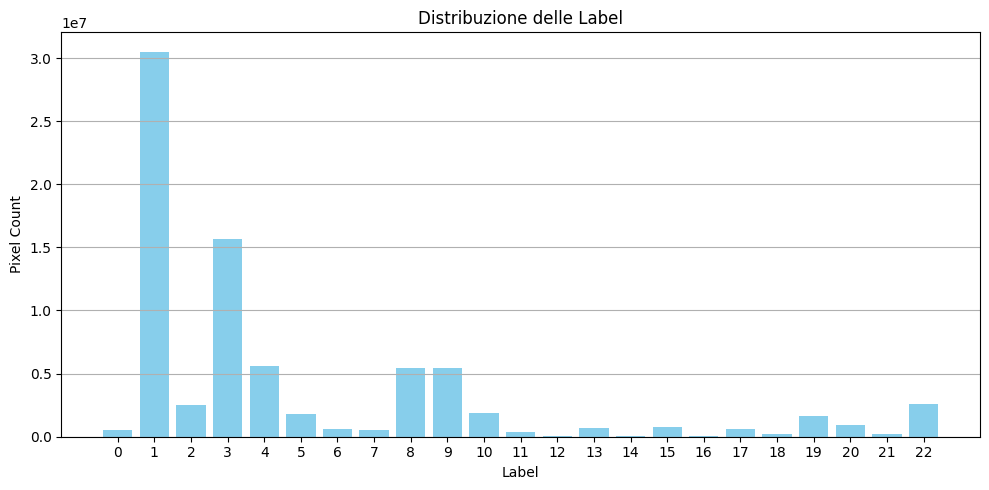

In [124]:
# Plot
labels = list(labels_count.keys())
values = list(labels_count.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Label")
plt.ylabel("Pixel Count")
plt.title("Distribuzione delle Label")
plt.grid(True, axis='y')
plt.xticks(labels)
plt.tight_layout()
plt.show()

I add a label column that maps the triple rgb to a label. In this way I know to which object the label corresponds to.

In [41]:
df=match_rgb2label(RESIZED_DATA_RGB_MASK,RESIZED_DATA_MASK,DATA_CLASS)

Processing 002.png...
Matched RGB [107 142  35] --> Label 8
Matched RGB [130  76   0] --> Label 2
Matched RGB [102 102 156] --> Label 10
Matched RGB [112 103  87] --> Label 4
Matched RGB [128  64 128] --> Label 1
Matched RGB [  0 102   0] --> Label 3
Matched RGB [51 51  0] --> Label 19
Matched RGB [  2 135 115] --> Label 22
Matched RGB [255  22  96] --> Label 15
Matched RGB [254 228  12] --> Label 11
Matched RGB [0 0 0] --> Label 0
Processing 001.png...
Matched RGB [190 153 153] --> Label 13
Matched RGB [112 150 146] --> Label 21
Matched RGB [153 153 153] --> Label 14
Matched RGB [70 70 70] --> Label 9
Matched RGB [190 250 190] --> Label 20
Matched RGB [254 148  12] --> Label 12
Processing 004.png...
Matched RGB [119  11  32] --> Label 18
Matched RGB [48 41 30] --> Label 6
Matched RGB [  9 143 150] --> Label 17
Processing 000.png...
Processing 003.png...
Processing 005.png...
Processing 006.png...
Matched RGB [ 28  42 168] --> Label 5
Processing 008.png...
Matched RGB [102  51   0] -->

In [49]:
df.iloc[-1, df.columns.get_loc('label')] = 23
df

,name,r,g,b,label
0,unlabeled,0,0,0,0.0
1,paved-area,128,64,128,1.0
2,dirt,130,76,0,2.0
3,grass,0,102,0,3.0
4,gravel,112,103,87,4.0
5,water,28,42,168,5.0
6,rocks,48,41,30,6.0
7,pool,0,50,89,7.0
8,vegetation,107,142,35,8.0
9,roof,70,70,70,9.0


### Creation train val test set

I divide the data in train test and validation set

In [59]:
image_path=[os.path.join(RESIZED_DATA_ORIGINAL,img) for img in sorted(os.listdir(RESIZED_DATA_ORIGINAL))]
mask_path=[os.path.join(RESIZED_DATA_MASK,img) for img in sorted(os.listdir(RESIZED_DATA_MASK))]

# train+val e test
X_temp, X_test, y_temp, y_test = train_test_split(
    image_path, mask_path, test_size=0.20, random_state=42
)

training_image_aug=[os.path.join(DATA_AUGMENTED,img) for img in sorted(os.listdir(DATA_AUGMENTED))]
training_mask_aug=[os.path.join(DATA_MASK_AUGMENTED,img) for img in sorted(os.listdir(DATA_MASK_AUGMENTED))]
training_image_aug+=X_temp
training_mask_aug+=y_temp

training_image=[os.path.join(CROPPED_DATA_ORIGINAL,img) for img in sorted(os.listdir(CROPPED_DATA_ORIGINAL))]
training_mask=[os.path.join(CROPPED_DATA_MASK,img) for img in sorted(os.listdir(CROPPED_DATA_MASK))]
training_image+=training_image_aug
training_mask+=training_mask_aug


# train e val
X_train, X_val, y_train, y_val = train_test_split(
    training_image, training_mask, test_size=0.10, random_state=42)

In [60]:
print(f"training:{len(X_train)}\nvale:{len(X_val)}\ntest:{len(X_test)}")

training:1008
vale:112
test:80


In [61]:
train_dataset=get_dataset(1,256,X_train, y_train)
val_dataset=get_dataset(1,256,X_val, y_val)
test_dataset=get_dataset(1,256,X_test, y_test)

In [62]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))


## Segmentation models



I develop 4 models:
- **UNET**
- **RESUNET**
- **SEGFORMER**
- **DEEPVLABV3+**

Each model section it's divided into:
1. **Building block of the model**
2. **Model definition**
3. **Compiling and training of the model**

To find the best hyperparameters I train **5 models** for each model type by using **random sweep agent** of wandb library.
The hyperparameters are defined in Constant.

Then I will take the model with the **best accuracy** score on validation

### U-Net

#### Building block

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)


    return x

In [ ]:
def downsample_block(x, n_filters,dropout):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(dropout)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters, dropout):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(dropout)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

#### U-NET model

In [ ]:
def UNet(input_shape=(256, 256, 3),num_classes=23,dropout=0.3):

    # inputs
    inputs = layers.Input(input_shape)

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64,dropout)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128,dropout)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256,dropout)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512,dropout)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512,dropout)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256,dropout)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128,dropout)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64,dropout)

    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = UNet()

In [ ]:
unet_model.summary()

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'Unet'), count=5)

### ResU-Net

#### Building block

In [ ]:
def residual_block(x, n_filters, next_block_res=True):
    shortcut = x
    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)


    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)


    # Adapt the shortcut if it is necessary by changing the number of channer by using Conv with 1x1 kernel size
    if shortcut.shape[-1] != n_filters:
        shortcut = layers.Conv2D(n_filters, 1, padding="same")(shortcut)

    x = layers.Add()([x, shortcut])

    if(next_block_res == False):
      x = layers.ReLU()(x)

    return x

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)


    return x

In [ ]:
def downsample_block(x, n_filters,dropout, next_block_res=True):
    f = residual_block(x, n_filters,next_block_res)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(dropout)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters,dropout):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(dropout)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

#### ResU-Net model

In [ ]:
def ResUnet(input_shape=(256, 256, 3),num_classes=23,dropout=0.3):

    # inputs
    inputs = layers.Input(input_shape)
    f0 = layers.Conv2D(64, 7, padding = "same", activation = "relu",strides=1,kernel_initializer = "he_normal")(inputs)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(f0, 64,dropout)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128,dropout)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256,dropout)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512,dropout,next_block_res=False)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512,dropout)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256,dropout)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128,dropout)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64,dropout)

    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    resunet_model = tf.keras.Model(inputs, outputs, name="ResU-Net")

    return resunet_model

In [ ]:
resunet_model = ResUnet()

In [ ]:
resunet_model.summary()

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'ResUnet'), count=5)

### SegFormer

#### Building blocks

In [ ]:
def mix_ffn(x, dropout):
    W = int(x.shape[1] ** 0.5)
    dim=x.shape[-1]
    x = layers.Dense(dim*2)(x)
    x = layers.Reshape((W, W, dim*2))(x)
    x = layers.DepthwiseConv2D(kernel_size=3, padding='same')(x)
    x = layers.Activation("gelu")(x)
    x = layers.Reshape((-1, dim*2))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dim)(x)
    return x#[4096 x 32]

In [ ]:
def transformer(encoded_patches,num_heads, projection_dim,dropout):
    # Layer normalization 1.
    x1 = layers.LayerNormalization()(encoded_patches)#[4096 x 32]

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=dropout
    )(x1, x1)#[4096 x32]

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization()(x2)

    # MLP layer 1.
    x4 = mix_ffn(x3, dropout)

    # Skip connection 2.
    encoded_patches = layers.Add()([x4, x2])# dim finale[num patcheds, projected_dim][4096,32]
    return encoded_patches

In [ ]:
def hierarchical_vit_encoder(img, transformer_layers=4,dropout=0.2):
    features = []
    patches = img
    embed_dims = [32, 64, 128, 256]
    kernel_sizes = [7, 3, 3, 3]  # Differentiated kernel sizes for each stage
    strides = [4, 2, 2, 2]       # H/4, H/8, H/16, H/32 respectively

    for i in range(len((embed_dims))):
        patches = layers.Conv2D(embed_dims[i], kernel_size=kernel_sizes[i], strides=strides[i], padding="same",kernel_initializer = "he_normal")(patches)
        h, w = ops.shape(patches)[1], ops.shape(patches)[2] #1) [1 x 64 x 64 x 32]
        x = layers.Reshape((-1, embed_dims[i]))(patches) #[4096 x 32]
        for _ in range(transformer_layers):
            x = transformer(x, num_heads=8, projection_dim=embed_dims[i],dropout=dropout)
        x_out = layers.Reshape((h, w, embed_dims[i]))(x)#[1 x 64 x 64 x 32]
        features.append(x_out)
    return features

In [ ]:
def segformer_decoder(features, embed_dims, num_classes):
    """
    Costruisce un decoder stile SegFormer.

    Args:
        features: lista di 4 feature map [F1, F2, F3, F4] provenienti dall'encoder
        embed_dims: lista con le dimensioni dei canali per ogni livello [C1, C2, C3, C4]
        num_classes: numero delle classi di segmentazione

    Returns:
        output: mappa segmentata finale (H x W x num_classes)
    """

    projected = []
    target_size = (64, 64)  # Risoluzione più alta (es. F1)

    for i in range(4):
        h_i, w_i =  ops.shape(features[i])[1],  ops.shape(features[i])[2]
        x = layers.Reshape((-1, features[i].shape[-1]))(features[i])    # (B, H_i*W_i, C_i)
        x = layers.Dense(256)(x)                                        # Proiezione MLP (Linear)
        x = layers.Reshape((h_i, w_i, 256))(x)

        x = layers.UpSampling2D(
            size=(target_size[0] // h_i, target_size[1] // w_i),
            interpolation="bilinear"
        )(x)

        projected.append(x)

    # Concateniamo lungo i canali → shape: (B, H, W, 4*256)
    x = layers.Concatenate(axis=-1)(projected)

    # MLP finale: Dense applicato punto per punto (equivalente a Linear 1x1)
    x = layers.Reshape((-1, 4 * 256))(x)                # (B, H*W, 1024)
    x = layers.Dense(256, activation='gelu')(x)         # (B, H*W, 256)
    x = layers.Dense(num_classes)(x)                    # (B, H*W, Ncls)
    x = layers.Reshape((target_size[0], target_size[1], num_classes))(x)  # (B, H, W, Ncls)
    x = layers.Softmax()(x)

    # Upsample alla dimensione finale
    x = layers.UpSampling2D(size=4, interpolation='bilinear')(x)

    return x

#### Segformer model

In [ ]:
def Segformer(input_shape=(256, 256, 3), num_classes=23 ,dropout=0.2):
    img = layers.Input(shape=input_shape)
    encoder_outputs = hierarchical_vit_encoder(img,dropout=dropout)
    decoder_output = segformer_decoder(encoder_outputs, [32, 64, 128, 256], num_classes)
    segformer = tf.keras.Model(inputs=img, outputs=decoder_output, name="SegFormer")

    return segformer


In [ ]:
model_seg_former = Segformer(input_shape=(256, 256, 3), num_classes=23)
model_seg_former.summary()

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'Segformer'), count=5)

Create sweep with ID: gtvam63b
Sweep URL: https://wandb.ai/SanRaffaele/Environment-Segmentation/sweeps/gtvam63b


wandb: Agent Starting Run: 0imfi8zy with config:
wandb: 	batch_size: 10
wandb: 	dropout: 0.5
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.1632 - loss: 4.5695 - val_accuracy: 0.2313 - val_loss: 4.3666 - learning_rate: 1.0000e-04
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - accuracy: 0.1746 - loss: 4.5819 - val_accuracy: 0.2313 - val_loss: 4.4476 - learning_rate: 1.0000e-04
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 450ms/step - accuracy: 0.1746 - loss: 4.6279 - val_accuracy: 0.2313 - val_loss: 4.4471 - learning_rate: 1.0000e-04
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 449ms/step - accuracy: 0.1746 - loss: 4.6278 - val_accuracy: 0.2313 - val_loss: 4.4469 - learning_rate: 1.0000e-04
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 450ms/step - accuracy: 0.1746 - loss: 4.6279 - val_accuracy: 0.2313 - val_loss: 4.4469 - learning_rate: 1.0000e-04
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.1744 - loss: 4.6287
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 449m

wandb: Adding directory to artifact (/content/wandb/run-20250720_164823-0imfi8zy/files/tensorboard_logs)... Done. 0.4s


epoch/accuracy,█████████████████████████████████████▁▆█
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,█████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▂▁▁▁▁
epoch/accuracy,0.19339
epoch/epoch,99
epoch/learning_rate,0.0
epoch/loss,4.16105
epoch/val_accuracy,0.23129


wandb: Agent Starting Run: gvo9l8fq with config:
wandb: 	batch_size: 5
wandb: 	dropout: 0.4
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 326s 893ms/step - accuracy: 0.3193 - loss: 6.3344 - val_accuracy: 0.2313 - val_loss: 4.1477 - learning_rate: 1.0000e-04
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.1741 - loss: 4.3269 - val_accuracy: 0.2313 - val_loss: 4.1477 - learning_rate: 1.0000e-04
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - accuracy: 0.1741 - loss: 4.3269 - val_accuracy: 0.2313 - val_loss: 4.1477 - learning_rate: 1.0000e-04
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 229ms/step - accuracy: 0.1741 - loss: 4.3269 - val_accuracy: 0.2313 - val_loss: 4.1477 - learning_rate: 1.0000e-04
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - accuracy: 0.1741 - loss: 4.3269 - val_accuracy: 0.2313 - val_loss: 4.1477 - learning_rate: 1.0000e-04
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.1740 - loss: 4.3271
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
202/202 ━━━━━━━━━━━━━━━━━━━━ 46s 2

wandb: Adding directory to artifact (/content/wandb/run-20250720_180954-gvo9l8fq/files/tensorboard_logs)... Done. 0.4s


epoch/accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
epoch/learning_rate,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.1934
epoch/epoch,99
epoch/learning_rate,0.0
epoch/loss,4.2971
epoch/val_accuracy,0.23129


wandb: Agent Starting Run: 6j8nljjw with config:
wandb: 	batch_size: 1
wandb: 	dropout: 0.3
wandb: 	epoch: 100
wandb: 	lr: 0.0001


Epoch 1/100
 891/1008 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.0908 - loss: 4.7096

### DeepLab v3 plus

#### Building blocks

In [ ]:
def convolution_block(block_input,num_filters=256,kernel_size=3,dilation_rate=1):
    x = layers.Conv2D(num_filters,kernel_size=kernel_size,dilation_rate=dilation_rate,padding="same",kernel_initializer = "he_normal")(block_input)
    x = layers.GroupNormalization(groups=x.shape[-1])(x)
    x = layers.ReLU()(x)
    return x


In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

#### DeeplabV3Plus model

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_tensor=preprocessed
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    print(x.shape)
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation="softmax")(x)
    deeplabv3 = tf.keras.Model(inputs=model_input, outputs=model_output, name="SegFormer")

    return deeplabv3




In [ ]:
model_deepLab = DeeplabV3Plus(image_size=256, num_classes=23)
model_deepLab.summary()

#### Compile and train

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Environment-Segmentation")
wandb.agent(sweep_id, function=lambda: train(X_train, X_val, y_train, y_val,'DeepLabV3Plus'), count=5)

## Test models

I load the best model for model type

In [54]:
models=os.listdir(MODELS)
print(models)

['best_unet', 'best_unet.keras', 'best_resunet.keras', 'best_segformer.keras', 'best_deepLabv3plus.keras']


In [56]:
unet_model=load_model(os.path.join(MODELS,'best_unet.keras'))
resUnet_model=load_model(os.path.join(MODELS,'best_resunet.keras'))
segformer_model=load_model(os.path.join(MODELS,'best_segformer.keras'))
deeplabv3_model=load_model(os.path.join(MODELS,'best_deepLabv3plus.keras'))

I inference each model on the test set

In [63]:
unet_prediction=unet_model.predict(test_dataset)
resUnet_prediction=resUnet_model.predict(test_dataset)
segformer_prediction=segformer_model.predict(test_dataset)
deeplabv3_prediction=deeplabv3_model.predict(test_dataset)

80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 506ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 567ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 318ms/step


In [66]:
unet_prediction=np.argmax(unet_prediction,axis=-1)
resUnet_prediction=np.argmax(resUnet_prediction,axis=-1)
segformer_prediction=np.argmax(segformer_prediction,axis=-1)
deeplabv3_prediction=np.argmax(deeplabv3_prediction,axis=-1)

In [64]:
y_true_all = []
for batch in test_dataset:
    image, mask = batch
    y_true_all.append(mask.numpy().squeeze())  # remove batch dim

y_true = np.stack(y_true_all, axis=0)


====== UNet ======
accuracy: 0.7951623916625976
precision_macro: 0.49944450291430287
recall_macro: 0.42247334240866435
f1_macro: 0.4442674417853332


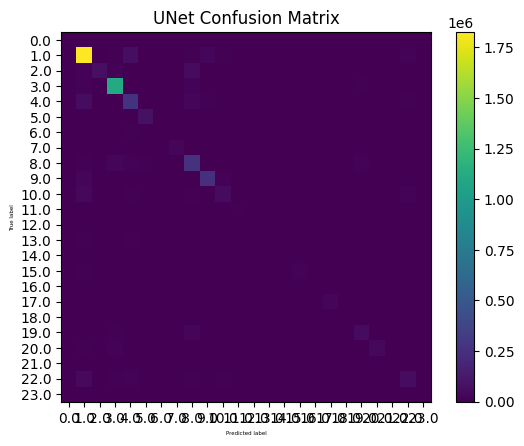

dice_class_0: 0.0008270443502532823
dice_class_1: 0.8925838756006832
dice_class_2: 0.5124490914366154
dice_class_3: 0.9314286551261637
dice_class_4: 0.6594135241935287
dice_class_5: 0.8178475802261919
dice_class_6: 0.15039832400694655
dice_class_7: 0.875402706185567
dice_class_8: 0.6533724993042886
dice_class_9: 0.8182672436115621
dice_class_10: 0.3985032813574601
dice_class_11: 0.4568350781368533
dice_class_12: 0.0
dice_class_13: 0.22086727321805683
dice_class_14: 0.0
dice_class_15: 0.4214431906487025
dice_class_16: 0.0
dice_class_17: 0.7821544048548174
dice_class_18: 0.2072025052192067
dice_class_19: 0.5659666481014317
dice_class_20: 0.5507119695474412
dice_class_21: 0.3541539504916921
dice_class_22: 0.3925897572305337
dice_class_23: 1.0
mean_dice: 0.48593410845199986

====== ResUNet ======
accuracy: 0.8139232635498047
precision_macro: 0.5017701931419255
recall_macro: 0.42511984670572806
f1_macro: 0.448983745706194


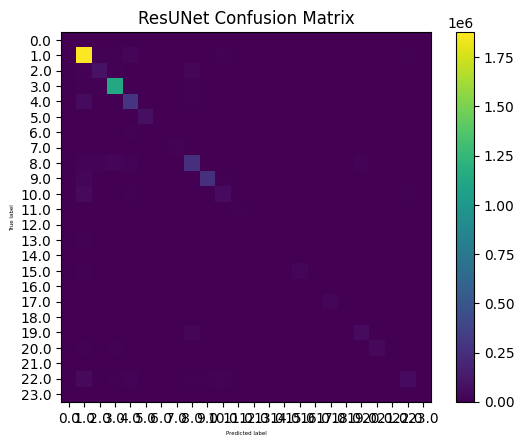

dice_class_0: 0.0
dice_class_1: 0.9044918472939095
dice_class_2: 0.5567301043263883
dice_class_3: 0.9408244340399067
dice_class_4: 0.7273240716452528
dice_class_5: 0.8839205233558034
dice_class_6: 0.1327050433010698
dice_class_7: 0.8616338374956032
dice_class_8: 0.6734635228521012
dice_class_9: 0.849847703784275
dice_class_10: 0.4085809493320916
dice_class_11: 0.3603755416466057
dice_class_12: 0.0
dice_class_13: 0.18356994630916698
dice_class_14: 0.0
dice_class_15: 0.4461243826227195
dice_class_16: 0.0
dice_class_17: 0.778273435536567
dice_class_18: 0.10441150416346778
dice_class_19: 0.6031813766500654
dice_class_20: 0.6009361249741606
dice_class_21: 0.38916535433070865
dice_class_22: 0.37005019328879335
dice_class_23: 1.0
mean_dice: 0.4906504123728606

====== Segformer ======
accuracy: 0.7164085388183594
precision_macro: 0.49139431387873694
recall_macro: 0.30289650625153236
f1_macro: 0.3397838819566637


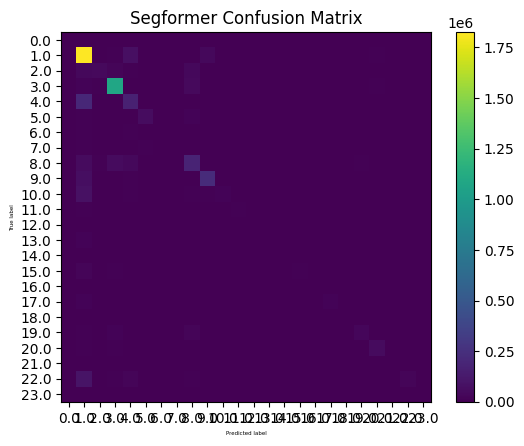

dice_class_0: 0.0
dice_class_1: 0.8098784993726574
dice_class_2: 0.35207894822645447
dice_class_3: 0.9003125700491063
dice_class_4: 0.43774510518083315
dice_class_5: 0.6717759106206644
dice_class_6: 0.04967261232783924
dice_class_7: 0.42518392012611667
dice_class_8: 0.4946495892872719
dice_class_9: 0.7421286680644142
dice_class_10: 0.18469140300342696
dice_class_11: 0.5087829058183743
dice_class_12: 0.0
dice_class_13: 0.14625367433861905
dice_class_14: 0.0
dice_class_15: 0.21237511157179464
dice_class_16: 0.0
dice_class_17: 0.600125041373984
dice_class_18: 0.23202630913230457
dice_class_19: 0.4280430282669924
dice_class_20: 0.6166277523274716
dice_class_21: 0.12911973299958282
dice_class_22: 0.21334238487202048
dice_class_23: 1.0
mean_dice: 0.3814505486233304

====== DeepLabV3 ======
accuracy: 0.4325523376464844
precision_macro: 0.1410541901214782
recall_macro: 0.08560056230022356
f1_macro: 0.07496514335895092


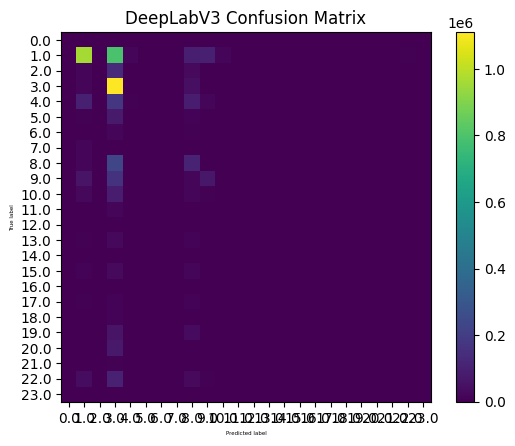

dice_class_0: 0.00045177320984865596
dice_class_1: 0.5855729343015198
dice_class_2: 0.003587514549676955
dice_class_3: 0.5160220632528546
dice_class_4: 0.024653379549393416
dice_class_5: 0.001927021818859949
dice_class_6: 0.0
dice_class_7: 0.0
dice_class_8: 0.25018293375752754
dice_class_9: 0.27381983834509743
dice_class_10: 0.04199510891201729
dice_class_11: 0.0
dice_class_12: 0.0
dice_class_13: 0.0
dice_class_14: 0.0
dice_class_15: 0.034097799336590934
dice_class_16: 0.0
dice_class_17: 0.0
dice_class_18: 0.0
dice_class_19: 0.05247206433723619
dice_class_20: 0.0
dice_class_21: 0.0
dice_class_22: 0.014381009244199213
dice_class_23: 1.0
mean_dice: 0.11663181002561758


In [80]:
models_predictions = {
    "UNet": unet_prediction,
    "ResUNet": resUnet_prediction,
    "Segformer": segformer_prediction,
    "DeepLabV3": deeplabv3_prediction,
}

for name, prediction in models_predictions.items():
    print(f"\n====== {name} ======")
    metrics, dice = evaluate_model(y_true, prediction,df)

    for k, v in metrics.items():
        if k != "confusion_matrix":
            print(f"{k}: {v}")
        else:
          ConfusionMatrixDisplay(v,
                                 display_labels=df['label'].unique(),
                                 ).plot(include_values=False)

          plt.title(f"{name} Confusion Matrix")
          plt.show()
    for k, v in dice.items():
        print(f"{k}: {v}")

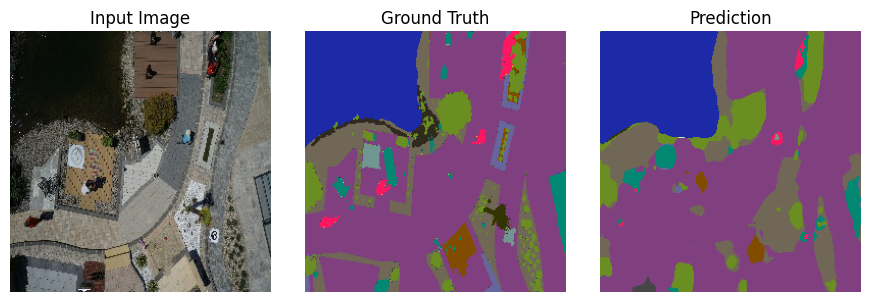

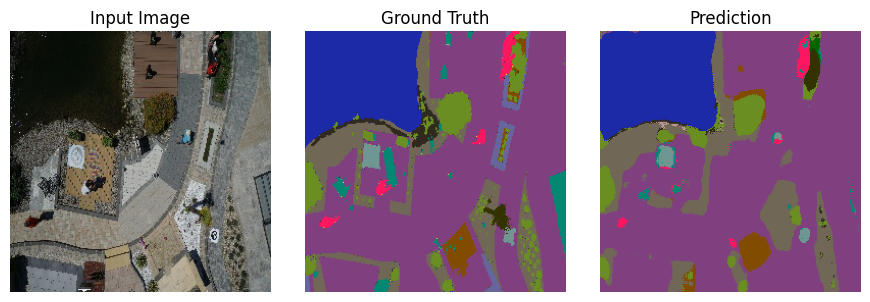

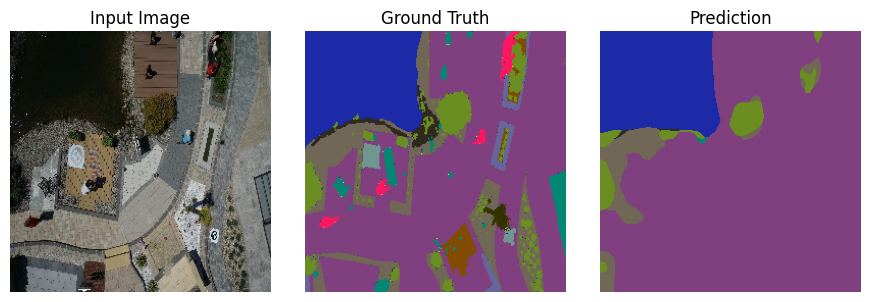

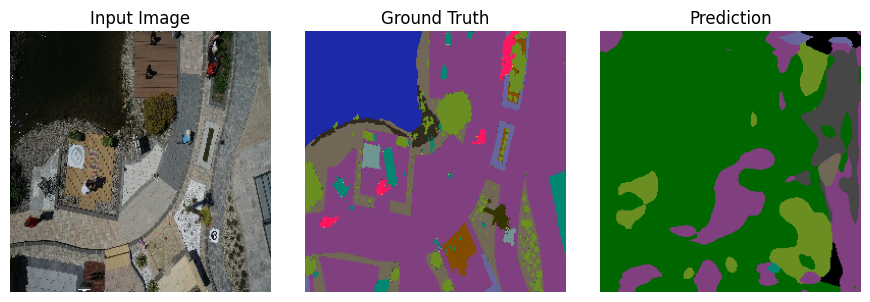

In [92]:
input_images = []
for batch in test_dataset:
    img, _ = batch
    input_images.append(img.numpy().squeeze())

input_images = np.stack(input_images)  # shape (80, 256, 256, 3)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=unet_prediction,
    data=df,
    index=0
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=resUnet_prediction,
    data=df,
    index=0
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=segformer_prediction,
    data=df,
    index=0
)

visualize_prediction(
    image=input_images,
    y_true=y_true,
    y_pred=deeplabv3_prediction,
    data=df,
    index=0
)


## Best spot to land

To find the best spot where the drone can land I do the following step:

1. I define a **score metric** based on the best semantic region
2. I **map each pixel** to this function score
3. I **clusterized** this new matrix of score by using a **hierarchical agglomerative clustering **algorithm
4. The best spot will be the cluster with the **best mean score**

### Score function

As a scoring function, I have different options, such as using the Hamming distance or defining a custom score, etc.
However, since the label assigned to each semantic zone seems meaningful, I decided to "normalize"/map the values using a Gaussian centered on the label of the best zone: **paved-area**.

$$
\text{score}(x) = \exp\left(-\left( \frac{x - \mu}{2\sigma} \right)^2\right)
$$

In [135]:
labels = df[['name','label']]
labels['label'].astype(int)

mu = df.loc[df['name']=='paved-area','label'].values[0]
sigma = np.std(labels['label'])

print(f"media:{mu}")
print(f"deviazione standard:{sigma}")

media:1.0
deviazione standard:6.922186552431729


Score definition

In [140]:
score_map = {}
for row in labels.iterrows():
    name = row[1]['name']
    val = row[1]['label']
    score_map[name] = gaussian_score(val, mu, sigma)

for k,v in score_map.items():
    print(f"{k}: {v:.4f}")


unlabeled: 0.9948
paved-area: 1.0000
dirt: 0.9948
grass: 0.9793
gravel: 0.9541
water: 0.9199
rocks: 0.8777
pool: 0.8288
vegetation: 0.7744
roof: 0.7161
wall: 0.6553
window: 0.5935
door: 0.5319
fence: 0.4718
fence-pole: 0.4141
person: 0.3597
dog: 0.3092
car: 0.2630
bicycle: 0.2214
tree: 0.1844
bald-tree: 0.1521
ar-marker: 0.1241
obstacle: 0.1002
conflicting: 0.0800


Map each pixel to this score

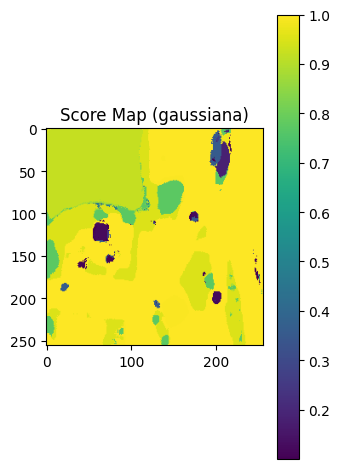

In [142]:
h, w = resUnet_prediction[0].shape
score_map_img = np.zeros((h, w), dtype=float)

for y in range(h):
    for x in range(w):
        val = resUnet_prediction[0][y, x]
        class_name = labels.loc[labels['label'] == val, 'name'].values[0]
        if class_name is None:
            score_map_img[y, x] = 0.0
        else:
            score_map_img[y, x] = score_map[class_name]

plt.subplot(1,2,2)
plt.title("Score Map (gaussiana)")
plt.imshow(score_map_img, cmap='viridis')
plt.colorbar()
plt.tight_layout()
plt.show()

### Clustering

In [159]:
# Array of shape (num_pixel, 3): [score, y, x]
h, w = score_map_img.shape
features = []
positions = []

for y in range(h):
    for x in range(w):
        score = score_map_img[y, x]
        features.append([score, y / h, x / w])  # normalize coordinates
        positions.append((y, x))

features = np.array(features)

print(f"Features shape: {features.shape}")
print(features)
print(f"\nPositions shape: {np.array(positions).shape}")
print(positions)


Features shape: (65536, 3)
[[1.         0.         0.        ]
 [0.77441128 0.         0.00390625]
 [0.95412888 0.         0.0078125 ]
 ...
 [1.         0.99609375 0.98828125]
 [1.         0.99609375 0.9921875 ]
 [1.         0.99609375 0.99609375]]

Positions shape: (65536, 2)
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0

I apply clustering.
I decided to create 64 clustering beacuse in this way we will have probably zones of at least 4x4 pixels

In [144]:
n_clusters = 64
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = clustering.fit_predict(features)

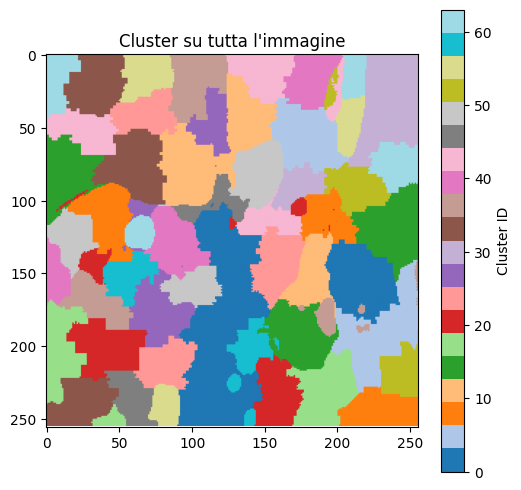

In [149]:
cluster_image = np.zeros((h, w), dtype=int)

for idx, (y, x) in enumerate(positions):
    cluster_image[y, x] = labels[idx]

plt.figure(figsize=(6, 6))
plt.title("Cluster su tutta l'immagine")
plt.imshow(cluster_image, cmap='tab20', vmin=0, vmax=n_clusters-1)
plt.colorbar(label='Cluster ID')
plt.show()

I compute mean score for eacg cluster

In [150]:
cluster_scores = np.zeros(n_clusters)
cluster_counts = np.zeros(n_clusters)

for idx, label in enumerate(labels):
    cluster_scores[label] += features[idx][0]  # somma score
    cluster_counts[label] += 1

# Calcolo media
for i in range(n_clusters):
    if cluster_counts[i] > 0:
        cluster_scores[i] /= cluster_counts[i]

In [152]:
cluster_scores.shape

(64,)

I order the clusters and I show the best 5 spot

In [156]:
cluster_score_list = []
for i, score in enumerate(cluster_scores):
    cluster_score_list.append((i, score))

# Ordinamento usando il parametro key con una funzione definita a parte
def get_score(item):
    return item[1]

sorted_clusters = sorted(cluster_score_list, key=get_score, reverse=True)
print(sorted_clusters)

[(1, np.float64(1.0)), (12, np.float64(1.0)), (17, np.float64(1.0)), (21, np.float64(1.0)), (24, np.float64(1.0)), (29, np.float64(1.0)), (30, np.float64(1.0)), (34, np.float64(1.0)), (40, np.float64(1.0)), (42, np.float64(1.0)), (47, np.float64(1.0)), (52, np.float64(1.0)), (60, np.float64(1.0)), (23, np.float64(0.9999132871087958)), (31, np.float64(0.9997617968574708)), (58, np.float64(0.9996225971734729)), (48, np.float64(0.9996061636900216)), (38, np.float64(0.9996048238795678)), (57, np.float64(0.9985784873592096)), (51, np.float64(0.9985490886792898)), (35, np.float64(0.9983311392138242)), (3, np.float64(0.9975476234511449)), (20, np.float64(0.9961328486393491)), (28, np.float64(0.9960763428155718)), (5, np.float64(0.9948394990622005)), (41, np.float64(0.9935596422552827)), (2, np.float64(0.9929784812578737)), (16, np.float64(0.9922384587506763)), (14, np.float64(0.9908554341619363)), (0, np.float64(0.9866007295586593)), (4, np.float64(0.9811324766164714)), (9, np.float64(0.97731

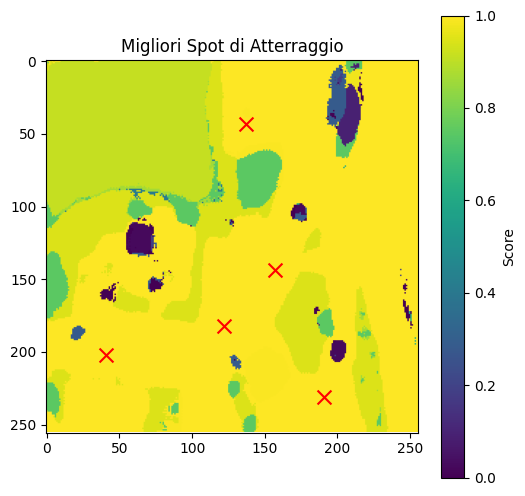

In [157]:
top_n = 5
best_spot_coords = []

for cluster_id, _ in sorted_clusters[:top_n]:
    pixels_in_cluster = [positions[i] for i in range(len(positions)) if labels[i] == cluster_id]
    # Calcoliamo il centroide
    ys = [p[0] for p in pixels_in_cluster]
    xs = [p[1] for p in pixels_in_cluster]
    centroid_y = int(np.mean(ys))
    centroid_x = int(np.mean(xs))
    best_spot_coords.append((centroid_y, centroid_x))

plt.figure(figsize=(6, 6))
plt.title("Migliori Spot di Atterraggio")
plt.imshow(score_map_img, cmap='viridis')
for (y, x) in best_spot_coords:
    plt.scatter(x, y, color='red', s=100, marker='x', label='Best spot')
plt.colorbar(label='Score')
plt.show()